# Exercise 7

# Capital Bikeshare data

## Introduction

- Capital Bikeshare dataset from Kaggle: [data](https://github.com/justmarkham/DAT8/blob/master/data/bikeshare.csv), [data dictionary](https://www.kaggle.com/c/bike-sharing-demand/data)
- Each observation represents the bikeshare rentals initiated during a given hour of a given day

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn.cross_validation import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, export_graphviz

C:\Users\nicol\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# read the data and set "datetime" as the index
url = 'https://raw.githubusercontent.com/justmarkham/DAT8/master/data/bikeshare.csv'
bikes = pd.read_csv(url, index_col='datetime', parse_dates=True)

In [3]:
# "count" is a method, so it's best to rename that column
bikes.rename(columns={'count':'total'}, inplace=True)

In [4]:
# create "hour" as its own feature
bikes['hour'] = bikes.index.hour

In [5]:
bikes.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,total,hour
datetime,,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,0
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,1
2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2
2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,3
2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,4


In [6]:
bikes.tail()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,total,hour
datetime,,,,,,,,,,,,
2012-12-19 19:00:00,4,0,1,1,15.58,19.695,50,26.0027,7,329,336,19
2012-12-19 20:00:00,4,0,1,1,14.76,17.425,57,15.0013,10,231,241,20
2012-12-19 21:00:00,4,0,1,1,13.94,15.910,61,15.0013,4,164,168,21
2012-12-19 22:00:00,4,0,1,1,13.94,17.425,61,6.0032,12,117,129,22
2012-12-19 23:00:00,4,0,1,1,13.12,16.665,66,8.9981,4,84,88,23


- **hour** ranges from 0 (midnight) through 23 (11pm)
- **workingday** is either 0 (weekend or holiday) or 1 (non-holiday weekday)

# Exercise 7.1

Run these two `groupby` statements and figure out what they tell you about the data.

In [7]:
# mean rentals for each value of "workingday"
bikes.groupby('workingday').total.mean()

workingday
0    188.506621
1    193.011873
Name: total, dtype: float64

In [8]:
print(bikes[bikes['workingday']==0]['total'].mean())
print(bikes[bikes['workingday']==1]['total'].mean())

188.50662061024755
193.01187263896384


Esto muestra que en promedio los días hábiles se alquilan mayor número de bicicletas

In [9]:
# mean rentals for each value of "hour"
bikes.groupby('hour').total.mean()

hour
0      55.138462
1      33.859031
2      22.899554
3      11.757506
4       6.407240
5      19.767699
6      76.259341
7     213.116484
8     362.769231
9     221.780220
10    175.092308
11    210.674725
12    256.508772
13    257.787281
14    243.442982
15    254.298246
16    316.372807
17    468.765351
18    430.859649
19    315.278509
20    228.517544
21    173.370614
22    133.576754
23     89.508772
Name: total, dtype: float64

En este caso se puede identificar los momentos del día en donde hay mayor cantidad de bicicletas alquiladas 

# Exercise 7.2

Run this plotting code, and make sure you understand the output. Then, separate this plot into two separate plots conditioned on "workingday". (In other words, one plot should display the hourly trend for "workingday=0", and the other should display the hourly trend for "workingday=1".)

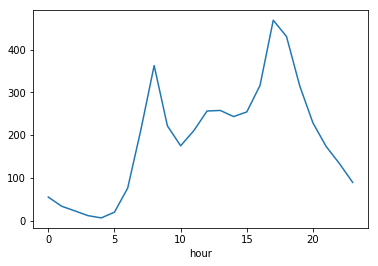

In [10]:
# mean rentals for each value of "hour"
bikes.groupby('hour').total.mean().plot()

Plot for workingday == 0 and workingday == 1

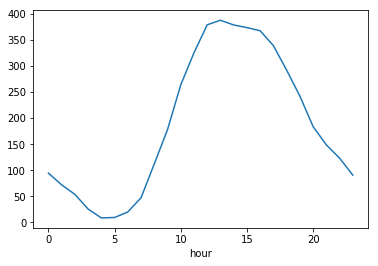

In [11]:
# hourly rental trend for "workingday=0"
bikes[bikes.workingday==0].groupby('hour').total.mean().plot()

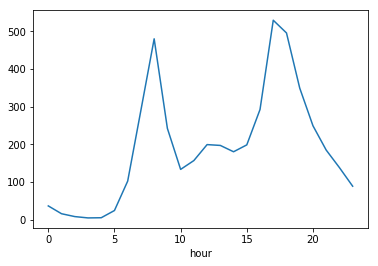

In [12]:
# hourly rental trend for "workingday=1"
bikes[bikes.workingday==1].groupby('hour').total.mean().plot()

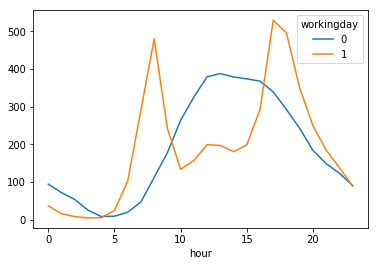

In [13]:
# combine the two plots
bikes.groupby(['hour', 'workingday']).total.mean().unstack().plot()

Write about your findings

El comportamiento del alquiler de bicicletas difiere dependiente el día de la semana, específicamente los días hábiles respecto a los fines de semana. Los días hábiles tienen dos picos de alquiler, uno en la mañana (7 - 9 am siendo las 8 am el mayor pico) otro en la tarde (5 pm - 7 pm siendo las 5pm el pico más alto). Mientras que el fin de semana el comportamiento no tiene un pico tan marcado, el rango es más amplio (11 am - 5 pm)

# Exercise 7.3

Fit a linear regression model to the entire dataset, using "total" as the response and "hour" and "workingday" as the only features. Then, print the coefficients and interpret them. What are the limitations of linear regression in this instance?

In [14]:
X_=bikes.loc[:,['workingday','hour']]
y_=bikes.loc[:,'total']

In [15]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(X_, y_)
print(lr.coef_)

[ 4.07248627 10.49206282]


# Exercice 7.4

Create a Decision Tree to forecast "total" by manually iterating over the features "hour" and "workingday". The algorithm must at least have 6 end nodes.

In [16]:
bikes.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,total,hour
datetime,,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,0
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,1
2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2
2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,3
2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,4


# Exercise 7.5

Train a Decision Tree using scikit-learn. Comment about the performance of the models.

In [17]:
# define X and y
X = bikes.loc[:,['workingday','hour']]
y = bikes.total

In [18]:
# instantiate a DecisionTreeRegressor (with random_state=1)
from sklearn.tree import DecisionTreeRegressor
treereg = DecisionTreeRegressor(random_state=1)
treereg

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=1, splitter='best')

In [19]:
# list of values to try
max_depth_range = range(1, 14)

# list to store the average RMSE for each value of max_depth
RMSE_scores = []

# use LOOCV with each value of max_depth
for depth in max_depth_range:
    treereg = DecisionTreeRegressor(max_depth=depth, random_state=1)
    MSE_scores = cross_val_score(treereg, X, y, cv=14, scoring='neg_mean_squared_error')
    RMSE_scores.append(np.mean(np.sqrt(-MSE_scores)))

In [20]:
RMSE_scores

[149.27606558022308,
 141.3258728334788,
 135.11248026264536,
 130.68509503469252,
 115.56676639118344,
 106.30130069442295,
 105.26224754923639,
 105.21443068870842,
 105.19650350761997,
 105.19244713068338,
 105.19244713068338,
 105.19244713068338,
 105.19244713068338]

Text(0,0.5,'RMSE (lower is better)')

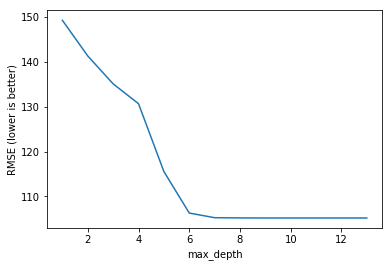

In [21]:
%matplotlib inline
import matplotlib.pyplot as plt
# plot max_depth (x-axis) versus RMSE (y-axis)
plt.plot(max_depth_range, RMSE_scores)
plt.xlabel('max_depth')
plt.ylabel('RMSE (lower is better)')

In [22]:
# instantiate a DecisionTreeRegressor (with random_state=1)
from sklearn.tree import DecisionTreeRegressor
treereg = DecisionTreeRegressor(max_depth=10,random_state=1)
treereg.fit(X,y)

DecisionTreeRegressor(criterion='mse', max_depth=10, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=1, splitter='best')

In [23]:
# "Gini importance" of each feature: the (normalized) total reduction of error brought by that feature
pd.DataFrame({'feature':['workingday','hour'], 'importance':treereg.feature_importances_}).sort_values(by=['importance'],ascending=False)

,feature,importance
1,hour,0.81505
0,workingday,0.18495


In [26]:
# create a Graphviz file
from sklearn.tree import export_graphviz
export_graphviz(treereg, out_file='bikes.dot', feature_names=['workingday','hour'])

# At the command line, run this to convert to PNG:
#   dot -Tpng tree_vehicles.dot -o tree_vehicles.png

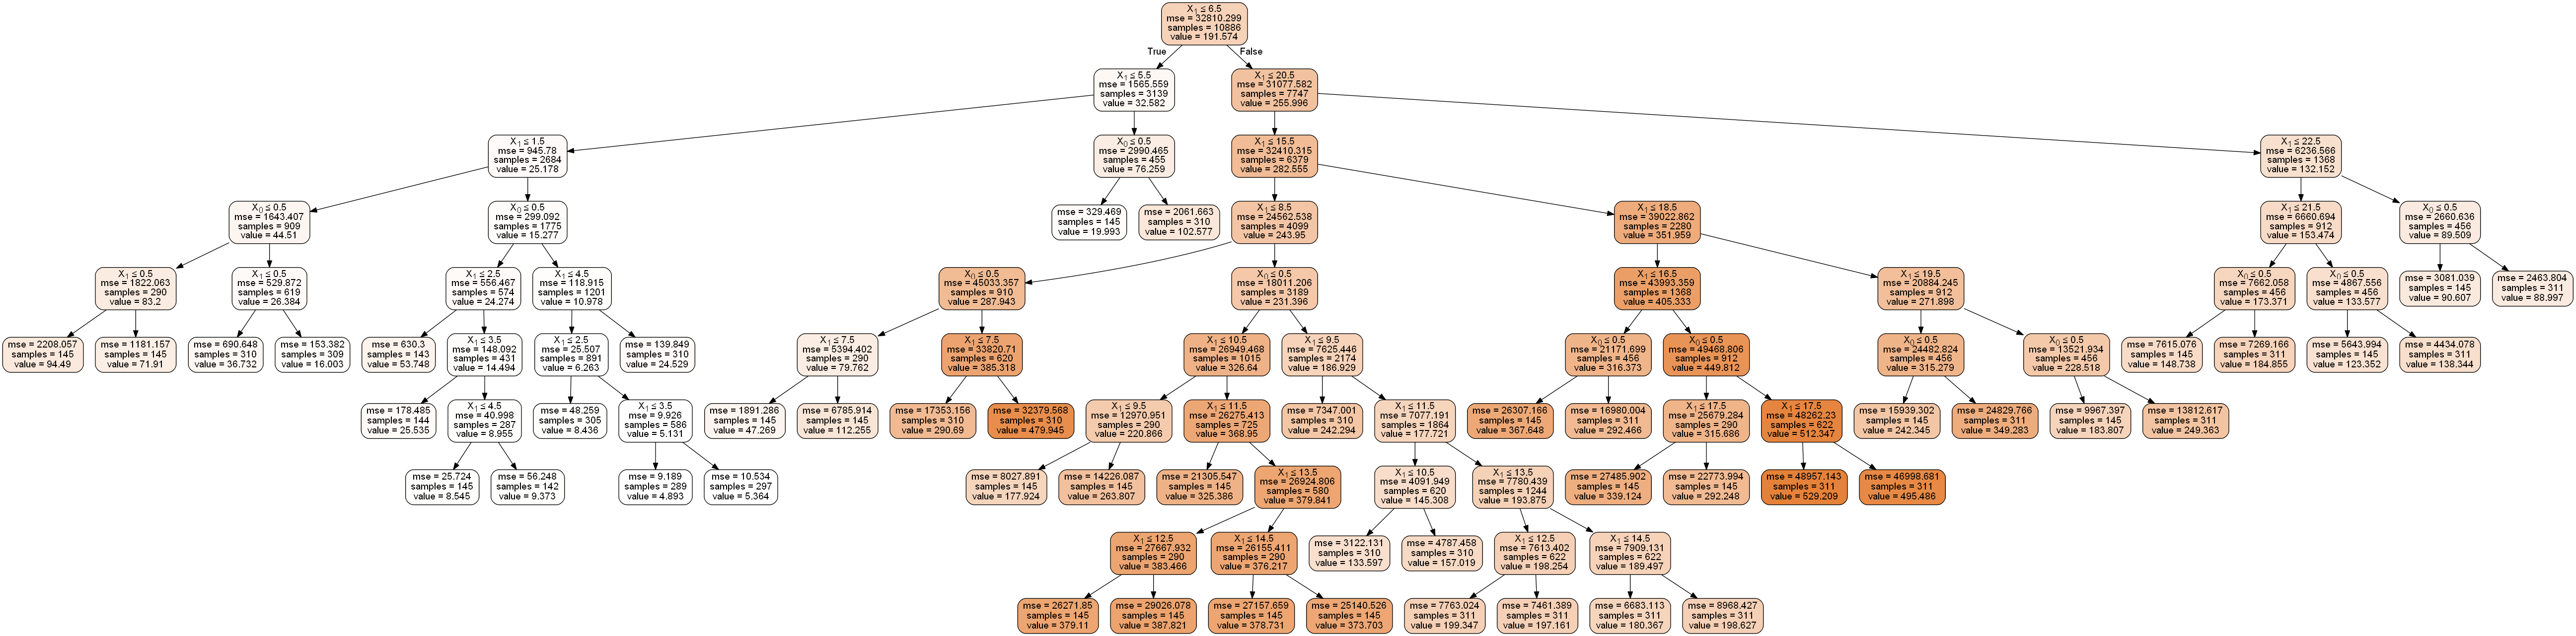

In [27]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
dot_data = StringIO()
export_graphviz(treereg, out_file=dot_data,filled=True, rounded=True,special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())